#### Imports

In [1]:
# download data
import re
import requests
import pandas as pd
from bs4 import BeautifulSoup

# decode data
from pymetdecoder import synop as s

#process data
import datetime as dt
import numpy as np
import matplotlib.pyplot as plt

In [2]:
def download_ogimet(dt_start, n_days=5,station='98430'):
    df = pd.DataFrame(columns=['datetime', 'precipitation', 'duration'])
    for i in range(n_days*8):
        tcdt = dt_start + dt.timedelta(hours=3*i)
        url = 'https://www.ogimet.com/cgi-bin/decomet?ind={station}&ano={yyyy}&mes={mm:02d}&day={dd:02d}&hora={hh:02d}&min=00&single=yes&lang=en'.format(station=station, yyyy=tcdt.year, mm=tcdt.month, dd=tcdt.day, hh=tcdt.hour)
        soup = BeautifulSoup(requests.get(url).content, "html.parser")
    
        synop = soup.find('pre').contents[0]
        synop = synop.replace('/\n                   ', ' ').replace('==', '')
        synopdt = dt.datetime.strptime(synop[:12], '%Y%m%d%H%M')
        synopd = s.SYNOP().decode(synop[13:])
    
        if synopd['precipitation_indicator']['value']==4:
            prcpt_amt = np.nan
            prcpt_dur = np.nan
        elif synopd['precipitation_indicator']['in_group_1']:
            prcpt_amt = synopd['precipitation_s1']['amount']['value']
            prcpt_dur = synopd['precipitation_s1']['time_before_obs']['value']
        elif synopd['precipitation_indicator']['in_group_3']:
            prcpt_amt = synopd['precipitation_s3']['amount']['value']
            prcpt_dur = synopd['precipitation_s3']['time_before_obs']['value']    
    
    
        df.loc[len(df.index)] = [tcdt, prcpt_amt, prcpt_dur] 
    return df

#### Carina + Habagat (2024)

In [3]:
tcdt_start = dt.datetime(2024,7,21,0,0)
df_h = download_ogimet(tcdt_start)

#### Ondoy (2009)

In [4]:
tcdt_start = dt.datetime(2009,9,24,0,0)
df_o = download_ogimet(tcdt_start)

#### Filter every 24hr

In [5]:
idxh = df_h['datetime'].dt.hour == 0
idxo = df_o['datetime'].dt.hour == 0

df_h_24 = df_h[idxh]
df_o_24 = df_o[idxo]

# fix first point for h+c (sorry tinatamad na ko mag-isip pano tanggalin ang NaT)
df_h_24.at[0, 'precipitation'] = 0
df_h_24.at[0, 'duration'] = 0

#### Calculate cumulative sum

In [6]:
df_h_24['cumulative'] = df_h_24.precipitation.cumsum()
df_o_24['cumulative'] = df_o_24.precipitation.cumsum()

/tmp/ipykernel_5141/1424257898.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_h_24['cumulative'] = df_h_24.precipitation.cumsum()
/tmp/ipykernel_5141/1424257898.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_o_24['cumulative'] = df_o_24.precipitation.cumsum()


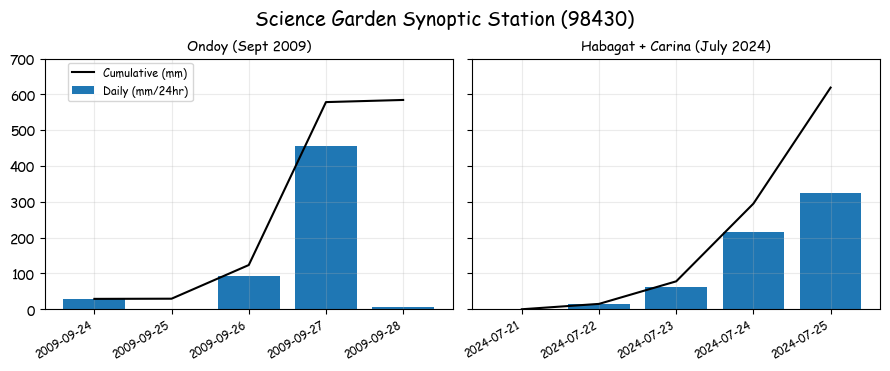

In [7]:
plt.rcParams["font.family"] = "Comic Sans MS"

fig, axs = plt.subplots(1,2,figsize=(9, 4), sharey=True)

fig.suptitle('Science Garden Synoptic Station (98430)', fontsize=14,  y=0.95)
cum_o = axs[0].plot(df_o_24['datetime'], df_o_24['cumulative'], color='k', label='Cumulative (mm)')
daily_o = axs[0].bar(df_o_24['datetime'], df_o_24['precipitation'], label='Daily (mm/24hr)')
axs[0].set_ylim([0,700])
axs[0].tick_params(axis='x', labelrotation=90, labelsize=8) 
axs[0].grid(alpha=0.25)
axs[0].set_title('Ondoy (Sept 2009)', fontsize=10)

cum_h = axs[1].plot(df_h_24['datetime'], df_h_24['cumulative'], color='k')
daily_h = axs[1].bar(df_h_24['datetime'], df_h_24['precipitation'])
axs[1].set_ylim([0,700])
axs[1].tick_params(axis='x', labelrotation=90, labelsize=8) 
axs[1].grid(alpha=0.25)
axs[1].set_title('Habagat + Carina (July 2024)' , fontsize=10)

fig.legend(['Cumulative (mm)', 'Daily (mm/24hr)'], loc='upper center', 
           bbox_to_anchor=(0.15, .83), ncol=1,
          fontsize=8)
plt.tight_layout()

import matplotlib.dates as mdates
axs[0].xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
axs[1].xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))

# rotate and align the tick labels so they look better
fig.autofmt_xdate()
plt.savefig('ondoy_carina.png', dpi=300)

plt.show()


#### Habagat (2012)

In [8]:
tcdt_start = dt.datetime(2012,8,5,0,0)
df_h2012 = download_ogimet(tcdt_start)

#### Filter every 24 hr and calculate cumulative sum

In [9]:
idxh2012 = df_h2012['datetime'].dt.hour == 0
df_h2012_24 = df_h2012[idxh2012]
df_h2012_24['cumulative'] = df_h2012_24.precipitation.cumsum()

/tmp/ipykernel_5141/1061850940.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_h2012_24['cumulative'] = df_h2012_24.precipitation.cumsum()


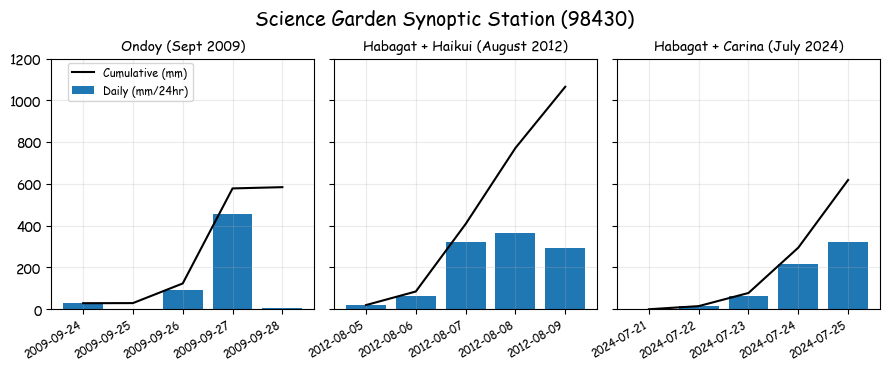

In [10]:
plt.rcParams["font.family"] = "Comic Sans MS"

fig, axs = plt.subplots(1,3,figsize=(9, 4), sharey=True)

fig.suptitle('Science Garden Synoptic Station (98430)', fontsize=14,  y=0.95)
cum_o = axs[0].plot(df_o_24['datetime'], df_o_24['cumulative'], color='k', label='Cumulative (mm)')
daily_o = axs[0].bar(df_o_24['datetime'], df_o_24['precipitation'], label='Daily (mm/24hr)')
axs[0].set_ylim([0,1200])
axs[0].tick_params(axis='x', labelrotation=90, labelsize=8) 
axs[0].grid(alpha=0.25)
axs[0].set_title('Ondoy (Sept 2009)', fontsize=10)

cum_h2012 = axs[1].plot(df_h2012_24['datetime'], df_h2012_24['cumulative'], color='k')
daily_h2012 = axs[1].bar(df_h2012_24['datetime'], df_h2012_24['precipitation'])
# axs[1].set_ylim([0,700])
axs[1].tick_params(axis='x', labelrotation=90, labelsize=8) 
axs[1].grid(alpha=0.25)
axs[1].set_title('Habagat + Haikui (August 2012)' , fontsize=10)

cum_h = axs[2].plot(df_h_24['datetime'], df_h_24['cumulative'], color='k')
daily_h = axs[2].bar(df_h_24['datetime'], df_h_24['precipitation'])
# axs[2].set_ylim([0,700])
axs[2].tick_params(axis='x', labelrotation=90, labelsize=8) 
axs[2].grid(alpha=0.25)
axs[2].set_title('Habagat + Carina (July 2024)' , fontsize=10)



fig.legend(['Cumulative (mm)', 'Daily (mm/24hr)'], loc='upper center', 
           bbox_to_anchor=(0.15, .83), ncol=1,
          fontsize=8)
plt.tight_layout()

import matplotlib.dates as mdates
axs[0].xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
axs[1].xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
axs[2].xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
# rotate and align the tick labels so they look better
fig.autofmt_xdate()
plt.savefig('ondoy_carina_haikui.png', dpi=300)

plt.show()
